In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, r2_score, accuracy_score, silhouette_score
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [65]:
#Loading the data
sales = pd.read_csv(r"C:\Users\aanas\Desktop\IronWork\GitHub\w5-nbs\D5\sales.csv") #training data
sales_real = pd.read_csv(r"C:\Users\aanas\Desktop\IronWork\GitHub\w5-nbs\D5\REAL_DATA.csv") #test data

display(sales.head())
display(sales_real.head())

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


,index,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday
0,272371,415,7,01/03/2015,0,0,0,0,0
1,558468,27,7,29/12/2013,0,0,0,0,0
2,76950,404,3,19/03/2014,657,1,1,0,0
3,77556,683,2,29/01/2013,862,1,0,0,0
4,456344,920,3,19/03/2014,591,1,1,0,0


In [66]:
# Convert 'state_holiday' column to boolean via dummies
sales = pd.get_dummies(sales, columns=['state_holiday'], prefix='state_holiday')


In [67]:
# Convert date column to datetime type
sales['date'] = pd.to_datetime(sales['date'])

# Extract year month date
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day'] = sales['date'].dt.day

In [68]:
# Drop the date column
sales.drop(columns=['date'], inplace=True)

In [69]:
# Convert 'state_holiday' column to boolean via dummies
sales_real = pd.get_dummies(sales_real, columns=['state_holiday'], prefix='state_holiday')


In [70]:
# Convert date column to datetime type
sales_real['date'] = pd.to_datetime(sales_real['date'], format='%d/%m/%Y')

# Extract year month date
sales_real['year'] = sales_real['date'].dt.year
sales_real['month'] = sales_real['date'].dt.month
sales_real['day'] = sales_real['date'].dt.day

In [71]:
# Drop the date column
sales_real.drop(columns=['date'], inplace=True)

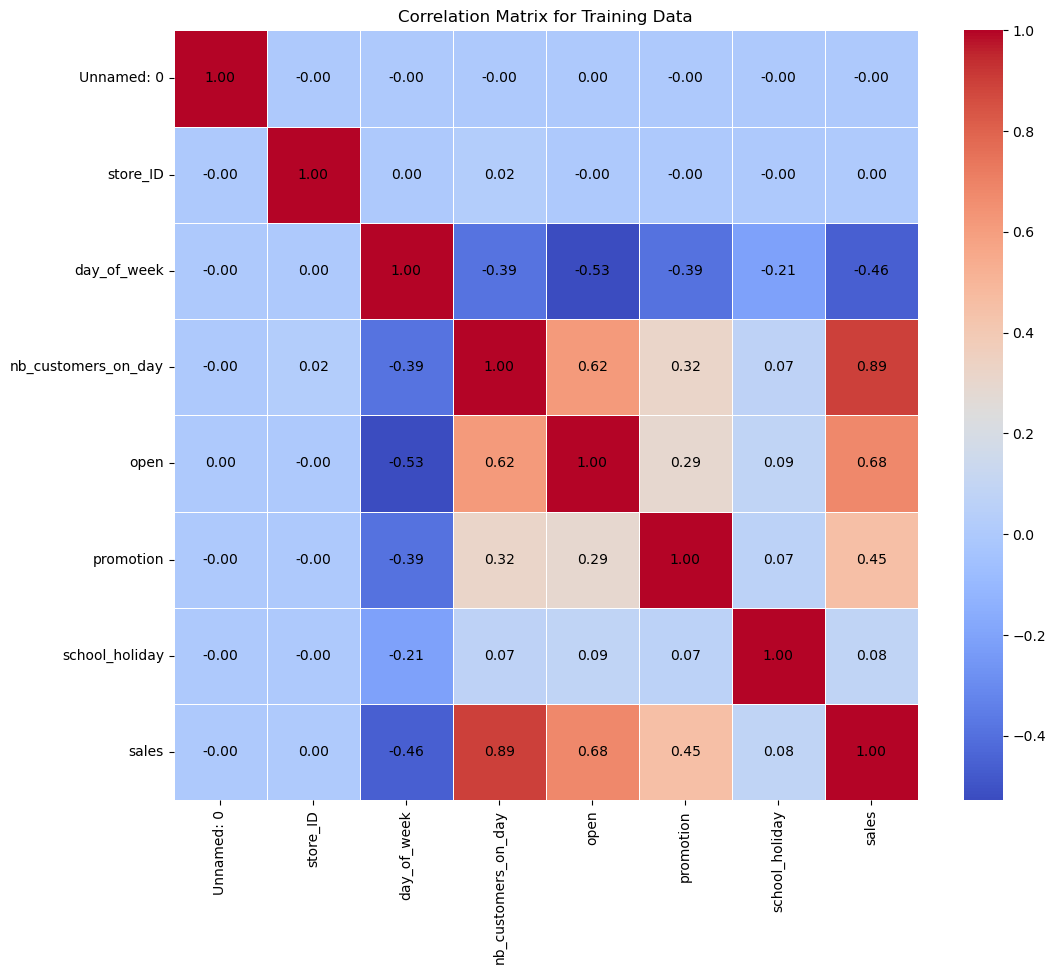

In [72]:
#Column collinearity - looking for high correlations between the variables

# Exclude non-numeric columns
numeric_df = sales.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr() 

# Create heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=.5)

# Annotate each cell with the correlation value
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        text = "{:.2f}".format(corr_matrix.iloc[i, j])
        heatmap.text(j+0.5, i+0.5, text, ha='center', va='center', color='black')

plt.title('Correlation Matrix for Training Data')
plt.show()

Considering the results above for the correlation matrix, we see that the variables with higher correlation are "nb_customers_on_day" and "sales" (89%)
This gives us an idea that the customers that go to the store have a high possibility of purchasing.
After analysis, we decided to keep both of the columns because: 
   1) sales is the variable we will predict 
   2) the correlation between variables is still <90%
   3) we don't think it will impact the sales prediction

We are converting the categorical variables into a format that can be provided to the machine learning algorithm we chose to improve the performance (using get_dummies function)

We decided to use XGBoost as this model is powerful for structured data and can handle a mix of numerical and categorical features. It can capture complex relationships in the data.

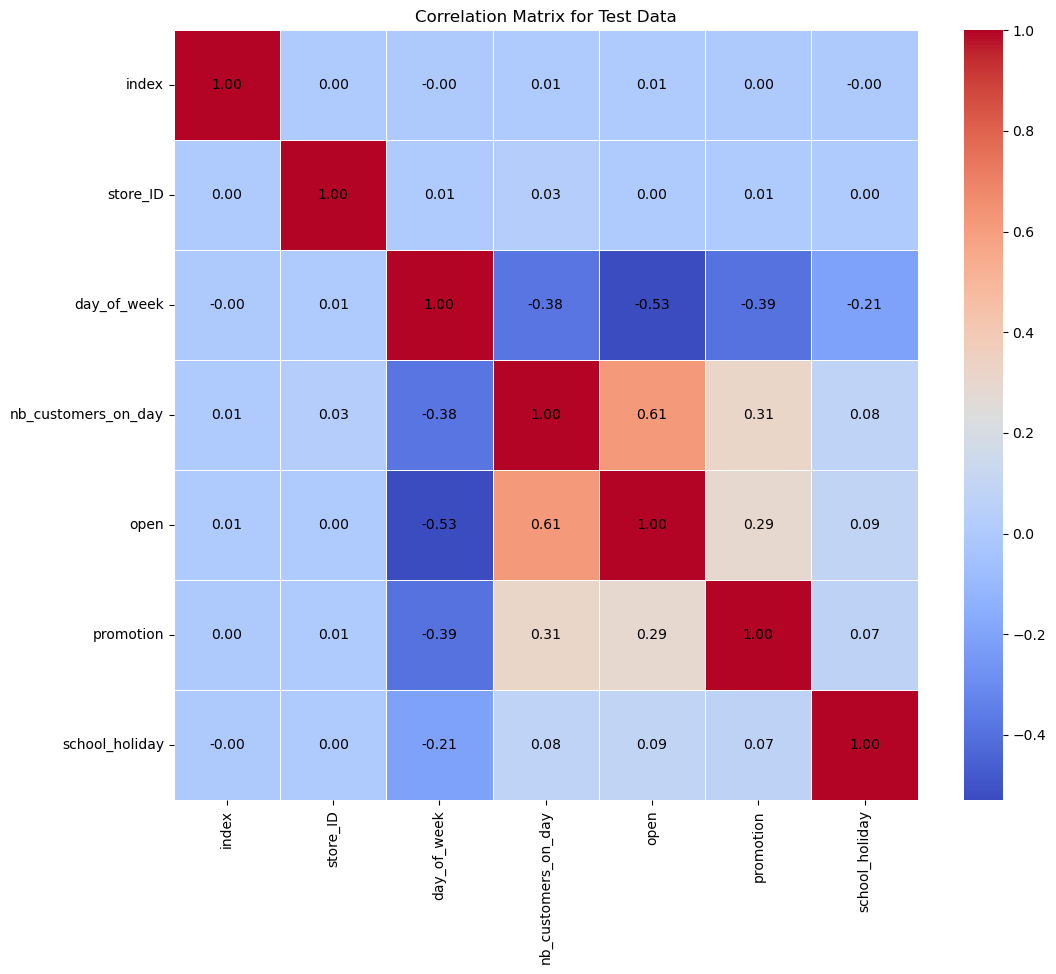

In [73]:
#Column collinearity - looking for high correlations between the variables

# Exclude non-numeric columns
numeric_df1 = sales_real.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
corr_matrix1 = numeric_df1.corr() 

# Create heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_matrix1, cmap='coolwarm', linewidths=.5)

# Annotate each cell with the correlation value
for i in range(len(corr_matrix1)):
    for j in range(len(corr_matrix1)):
        text = "{:.2f}".format(corr_matrix1.iloc[i, j])
        heatmap.text(j+0.5, i+0.5, text, ha='center', va='center', color='black')

plt.title('Correlation Matrix for Test Data')
plt.show()

In [74]:
#Drop columns  unamed and index as they do not match for predictions and their correlation is 0 meaning most probably they are not important for our model
sales = sales.drop(columns=['Unnamed: 0'])
sales_real = sales_real.drop(columns=['index'])

In [75]:
# Extract features 
X_train = sales.dropna(subset=['sales'])  # Features used for prediction
y_train = X_train['sales']  # Actual sales values

# Drop the 'sales' column from X_train to create features-only DataFrame
X_train = X_train.drop(columns=['sales'])

# Fit an XGBoost regression model
model = XGBRegressor()
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [76]:
# Make predictions on sales_real
predicted_sales = model.predict(sales_real)


In [77]:
# Create a copy of sales_real to store predictions
sales_real_predicted = sales_real.copy()

In [78]:
# Predict sales only for rows where 'open' is 1
sales_real_open = sales_real[sales_real['open'] == 1]
predicted_sales = model.predict(sales_real_open)

In [79]:
#Add the sales predictions in the sales_real_predicted DataFrame
sales_real_predicted.loc[sales_real_predicted['open'] == 1, 'sales'] = predicted_sales

In [80]:
#Add sales to 0 where 'open' is 0
sales_real_predicted.loc[sales_real_predicted['open'] == 0, 'sales'] = 0

In [81]:
# Print the first few rows of sales_real_predicted to check the predictions
display(sales_real_predicted.head())


,store_ID,day_of_week,nb_customers_on_day,open,promotion,school_holiday,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c,year,month,day,sales
0,415,7,0,0,0,0,True,False,False,False,2015,3,1,0.000000
1,27,7,0,0,0,0,True,False,False,False,2013,12,29,0.000000
2,404,3,657,1,1,0,True,False,False,False,2014,3,19,6710.856445
3,683,2,862,1,0,0,True,False,False,False,2013,1,29,6722.255371
4,920,3,591,1,1,0,True,False,False,False,2014,3,19,5857.863281


In [84]:
# Save the new DataFrame to a CSV file
sales_real_predicted.to_csv(r"C:\Users\aanas\Desktop\IronWork\GitHub\w5-nbs\D5\G2.csv", index=False)


In [82]:
#cross-validation
cv_scores = cross_val_score(model, X_train,y_train, cv=5, scoring='r2')

#average R2 score
expected_r2 = cv_scores.mean()

print(f"Expected R2 score: {expected_r2}")

Expected R2 score: 0.933909279215761


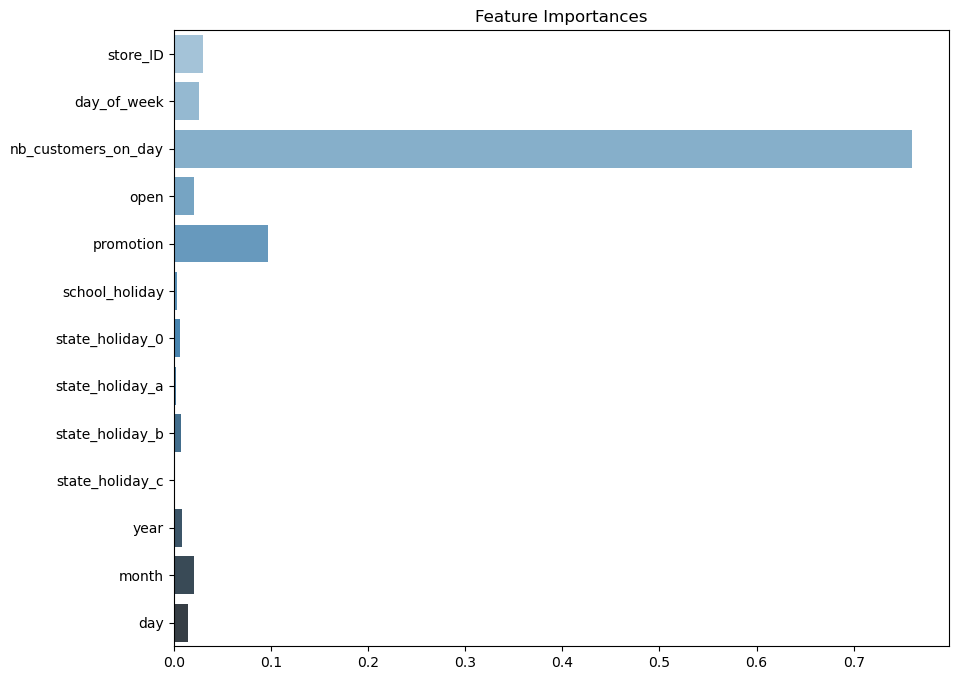

In [83]:
# Feature Importance, to visualize the importance of features in the XGBoost model (which feature contributes most to the predictions)
plt.figure(figsize=(10, 8))
feature_importances = model.feature_importances_
features = X_train.columns
sns.barplot(x=feature_importances, y=features, palette="Blues_d")
plt.title('Feature Importances')
plt.show()

